In [ ]:
import sys
import time
import os.path
from glob import glob
from datetime import datetime, timedelta

# data tools
import h5py
import numpy as np
import numba as nb
import pandas as pd

from scipy.ndimage import gaussian_filter1d

# custom tools
sys.path.insert(0, '/glade/u/home/ksha/WORKSPACE/utils/')
sys.path.insert(0, '/glade/u/home/ksha/WORKSPACE/Analog_BC/')
sys.path.insert(0, '/glade/u/home/ksha/WORKSPACE/Analog_BC/utils/')

import analog_utils as ana
import data_utils as du
import graph_utils as gu

from namelist import * 

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
# graph tools
import cmaps
import cartopy.crs as ccrs
import cartopy.mpl.geoaxes
import cartopy.feature as cfeature
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.colors as colors
import matplotlib.patches as patches
from matplotlib.collections import PatchCollection

from matplotlib import ticker
import matplotlib.ticker as mticker
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

%matplotlib inline

### Graph info

In [4]:
# Cartopy map settings
scale_param = '50m' # 10m for publication quality
# US states and CAN-US boundary
PROVINCE = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale=scale_param,
    facecolor='none')

In [5]:
def aspc_cal(edge):
    return (edge[3]-edge[2])/(edge[1]-edge[0])

In [6]:
A = cmaps.prcp_1(range(15))
A[0, :3] = [0.85, 0.85, 0.85]
A[-1, :3] = [0.55, 0.0, 0.0]
cmap_pct = colors.ListedColormap(A, 'hist')
cmap_pct.set_over([0.35, 0.0, 0.0])

In [7]:
fig_keys = {'dpi':250, 
            'orientation':'portrait', 
            'papertype':'a4',
            'bbox_inches':'tight', 
            'pad_inches':0.1, 
            'transparent':False}

### Geo info

In [8]:
# importing domain information
with h5py.File(save_dir+'BC_domain_info.hdf', 'r') as h5io:
    base_lon = h5io['base_lon'][...]
    base_lat = h5io['base_lat'][...]
    bc_lon = h5io['bc_lon'][...]
    bc_lat = h5io['bc_lat'][...]
    etopo_bc = h5io['etopo_bc'][...]
    land_mask = h5io['land_mask_base'][...]
    land_mask_bc = h5io['land_mask_bc'][...]

### Datetime info

In [9]:
mon_rain = np.array([9, 10, 11, 0, 1, 2])
mon_dry = np.array([3, 4, 5, 6, 7, 8])

base = datetime(2017, 1, 1)
date_list = [base + timedelta(days=x) for x in range(365+365+365)]

rain_inds = np.zeros((len(date_list),), dtype=bool)
dry_inds = np.zeros((len(date_list),), dtype=bool)

mon_inds = []
for d, date in enumerate(date_list):
    
    mon_inds.append(date.month-1)
    if date.month-1 in mon_dry:
        dry_inds[d] = True
    else:
        rain_inds[d] = True
        
mon_inds = np.array(mon_inds)

### Importing eval results

In [36]:
with h5py.File(save_dir+'BASE_QM_final_BCH_CRPS_2017.hdf', 'r') as h5io:
    BASE_MAE_sw_17 = h5io['MAE_sw'][...]
    BASE_MAE_si_17 = h5io['MAE_si'][...]
    BASE_MAE_n_17 = h5io['MAE_n'][...]
    BASE_CRPS_sw_17 = h5io['CRPS_sw'][...]
    BASE_CRPS_si_17 = h5io['CRPS_si'][...]
    BASE_CRPS_n_17 = h5io['CRPS_n'][...]
    OBS_sw_17 = h5io['OBS_sw'][...]
    OBS_si_17 = h5io['OBS_si'][...]
    OBS_n_17  = h5io['OBS_n'][...]
    
with h5py.File(save_dir+'SL_QM_final_BCH_CRPS_2017.hdf', 'r') as h5io:
    SL_MAE_sw_17 = h5io['MAE_sw'][...]
    SL_MAE_si_17 = h5io['MAE_si'][...]
    SL_MAE_n_17 = h5io['MAE_n'][...]
    SL_CRPS_sw_17 = h5io['CRPS_sw'][...]
    SL_CRPS_si_17 = h5io['CRPS_si'][...]
    SL_CRPS_n_17 = h5io['CRPS_n'][...]
    
with h5py.File(save_dir+'CNN_QM_BCH_CRPS_2017.hdf', 'r') as h5io:
    CNN_MAE_sw_17 = h5io['MAE_sw'][...]
    CNN_MAE_si_17 = h5io['MAE_si'][...]
    CNN_MAE_n_17 = h5io['MAE_n'][...]
    CNN_CRPS_sw_17 = h5io['CRPS_sw'][...]
    CNN_CRPS_si_17 = h5io['CRPS_si'][...]
    CNN_CRPS_n_17 = h5io['CRPS_n'][...]
    
with h5py.File(save_dir+'GEFS_BCH_CRPS_2017.hdf', 'r') as h5io:
    GEFS_MAE_sw_17 = h5io['MAE_sw'][...]
    GEFS_MAE_si_17 = h5io['MAE_si'][...]
    GEFS_MAE_n_17 = h5io['MAE_n'][...]
    GEFS_CRPS_sw_17 = h5io['CRPS_sw'][...]
    GEFS_CRPS_si_17 = h5io['CRPS_si'][...]
    GEFS_CRPS_n_17 = h5io['CRPS_n'][...]

In [37]:
with h5py.File(save_dir+'BASE_QM_final_BCH_CRPS_2018.hdf', 'r') as h5io:
    BASE_MAE_sw_18 = h5io['MAE_sw'][...]
    BASE_MAE_si_18 = h5io['MAE_si'][...]
    BASE_MAE_n_18 = h5io['MAE_n'][...]
    BASE_CRPS_sw_18 = h5io['CRPS_sw'][...]
    BASE_CRPS_si_18 = h5io['CRPS_si'][...]
    BASE_CRPS_n_18 = h5io['CRPS_n'][...]
    OBS_sw_18 = h5io['OBS_sw'][...]
    OBS_si_18 = h5io['OBS_si'][...]
    OBS_n_18  = h5io['OBS_n'][...]
    
with h5py.File(save_dir+'SL_QM_final_BCH_CRPS_2018.hdf', 'r') as h5io:
    SL_MAE_sw_18 = h5io['MAE_sw'][...]
    SL_MAE_si_18 = h5io['MAE_si'][...]
    SL_MAE_n_18 = h5io['MAE_n'][...]
    SL_CRPS_sw_18 = h5io['CRPS_sw'][...]
    SL_CRPS_si_18 = h5io['CRPS_si'][...]
    SL_CRPS_n_18 = h5io['CRPS_n'][...]
    
with h5py.File(save_dir+'CNN_QM_BCH_CRPS_2018.hdf', 'r') as h5io:
    CNN_MAE_sw_18 = h5io['MAE_sw'][...]
    CNN_MAE_si_18 = h5io['MAE_si'][...]
    CNN_MAE_n_18 = h5io['MAE_n'][...]
    CNN_CRPS_sw_18 = h5io['CRPS_sw'][...]
    CNN_CRPS_si_18 = h5io['CRPS_si'][...]
    CNN_CRPS_n_18 = h5io['CRPS_n'][...]
    
with h5py.File(save_dir+'GEFS_BCH_CRPS_2018.hdf', 'r') as h5io:
    GEFS_MAE_sw_18 = h5io['MAE_sw'][...]
    GEFS_MAE_si_18 = h5io['MAE_si'][...]
    GEFS_MAE_n_18 = h5io['MAE_n'][...]
    GEFS_CRPS_sw_18 = h5io['CRPS_sw'][...]
    GEFS_CRPS_si_18 = h5io['CRPS_si'][...]
    GEFS_CRPS_n_18 = h5io['CRPS_n'][...]

In [38]:
with h5py.File(save_dir+'BASE_QM_final_BCH_CRPS_2019.hdf', 'r') as h5io:
    BASE_MAE_sw_19 = h5io['MAE_sw'][...]
    BASE_MAE_si_19 = h5io['MAE_si'][...]
    BASE_MAE_n_19 = h5io['MAE_n'][...]
    BASE_CRPS_sw_19 = h5io['CRPS_sw'][...]
    BASE_CRPS_si_19 = h5io['CRPS_si'][...]
    BASE_CRPS_n_19 = h5io['CRPS_n'][...]
    OBS_sw_19 = h5io['OBS_sw'][...]
    OBS_si_19 = h5io['OBS_si'][...]
    OBS_n_19  = h5io['OBS_n'][...]
    
with h5py.File(save_dir+'SL_QM_final_BCH_CRPS_2019.hdf', 'r') as h5io:
    SL_MAE_sw_19 = h5io['MAE_sw'][...]
    SL_MAE_si_19 = h5io['MAE_si'][...]
    SL_MAE_n_19 = h5io['MAE_n'][...]
    SL_CRPS_sw_19 = h5io['CRPS_sw'][...]
    SL_CRPS_si_19 = h5io['CRPS_si'][...]
    SL_CRPS_n_19 = h5io['CRPS_n'][...]
    
with h5py.File(save_dir+'CNN_QM_BCH_CRPS_2019.hdf', 'r') as h5io:
    CNN_MAE_sw_19 = h5io['MAE_sw'][...]
    CNN_MAE_si_19 = h5io['MAE_si'][...]
    CNN_MAE_n_19 = h5io['MAE_n'][...]
    CNN_CRPS_sw_19 = h5io['CRPS_sw'][...]
    CNN_CRPS_si_19 = h5io['CRPS_si'][...]
    CNN_CRPS_n_19 = h5io['CRPS_n'][...]
    
with h5py.File(save_dir+'GEFS_BCH_CRPS_2019.hdf', 'r') as h5io:
    GEFS_MAE_sw_19 = h5io['MAE_sw'][...]
    GEFS_MAE_si_19 = h5io['MAE_si'][...]
    GEFS_MAE_n_19 = h5io['MAE_n'][...]
    GEFS_CRPS_sw_19 = h5io['CRPS_sw'][...]
    GEFS_CRPS_si_19 = h5io['CRPS_si'][...]
    GEFS_CRPS_n_19 = h5io['CRPS_n'][...]

In [13]:
with h5py.File(save_dir+'ERA5_BCH_MAE_2017.hdf', 'r') as h5io:
    MAE_sw_17 = h5io['MAE_sw'][...]
    MAE_si_17 = h5io['MAE_si'][...]
    MAE_n_17 = h5io['MAE_n'][...]
    
with h5py.File(save_dir+'ERA5_BCH_MAE_2018.hdf', 'r') as h5io:
    MAE_sw_18 = h5io['MAE_sw'][...]
    MAE_si_18 = h5io['MAE_si'][...]
    MAE_n_18 = h5io['MAE_n'][...]
    
with h5py.File(save_dir+'ERA5_BCH_MAE_2019.hdf', 'r') as h5io:
    MAE_sw_19 = h5io['MAE_sw'][...]
    MAE_si_19 = h5io['MAE_si'][...]
    MAE_n_19 = h5io['MAE_n'][...]

In [14]:
MAE_sw = np.concatenate((MAE_sw_17, MAE_sw_18, MAE_sw_19), axis=0)
MAE_si = np.concatenate((MAE_si_17, MAE_si_18, MAE_si_19), axis=0)
MAE_n = np.concatenate((MAE_n_17, MAE_n_18, MAE_n_19), axis=0)

In [40]:
BASE_MAE_sw = np.concatenate((BASE_MAE_sw_17, BASE_MAE_sw_18, BASE_MAE_sw_19), axis=0)
BASE_MAE_si = np.concatenate((BASE_MAE_si_17, BASE_MAE_si_18, BASE_MAE_si_19), axis=0)
BASE_MAE_n = np.concatenate((BASE_MAE_n_17, BASE_MAE_n_18, BASE_MAE_n_19), axis=0)

BASE_CRPS_sw = np.concatenate((BASE_CRPS_sw_17, BASE_CRPS_sw_18, BASE_CRPS_sw_19), axis=0)
BASE_CRPS_si = np.concatenate((BASE_CRPS_si_17, BASE_CRPS_si_18, BASE_CRPS_si_19), axis=0)
BASE_CRPS_n = np.concatenate((BASE_CRPS_n_17, BASE_CRPS_n_18, BASE_CRPS_n_19), axis=0)

In [39]:
SL_MAE_sw = np.concatenate((SL_MAE_sw_17, SL_MAE_sw_18, SL_MAE_sw_19), axis=0)
SL_MAE_si = np.concatenate((SL_MAE_si_17, SL_MAE_si_18, SL_MAE_si_19), axis=0)
SL_MAE_n = np.concatenate((SL_MAE_n_17, SL_MAE_n_18, SL_MAE_n_19), axis=0)

SL_CRPS_sw = np.concatenate((SL_CRPS_sw_17, SL_CRPS_sw_18, SL_CRPS_sw_19), axis=0)
SL_CRPS_si = np.concatenate((SL_CRPS_si_17, SL_CRPS_si_18, SL_CRPS_si_19), axis=0)
SL_CRPS_n = np.concatenate((SL_CRPS_n_17, SL_CRPS_n_18, SL_CRPS_n_19), axis=0)

In [54]:
CNN_MAE_sw = np.concatenate((CNN_MAE_sw_17, CNN_MAE_sw_18, CNN_MAE_sw_19), axis=0)
CNN_MAE_si = np.concatenate((CNN_MAE_si_17, CNN_MAE_si_18, CNN_MAE_si_19), axis=0)
CNN_MAE_n = np.concatenate((CNN_MAE_n_17, CNN_MAE_n_18, CNN_MAE_n_19), axis=0)

CNN_CRPS_sw = np.concatenate((CNN_CRPS_sw_17, CNN_CRPS_sw_18, CNN_CRPS_sw_19), axis=0)
CNN_CRPS_si = np.concatenate((CNN_CRPS_si_17, CNN_CRPS_si_18, CNN_CRPS_si_19), axis=0)
CNN_CRPS_n = np.concatenate((CNN_CRPS_n_17, CNN_CRPS_n_18, CNN_CRPS_n_19), axis=0)

In [50]:
GEFS_MAE_sw = np.concatenate((GEFS_MAE_sw_17, GEFS_MAE_sw_18, GEFS_MAE_sw_19), axis=0)
GEFS_MAE_si = np.concatenate((GEFS_MAE_si_17, GEFS_MAE_si_18, GEFS_MAE_si_19), axis=0)
GEFS_MAE_n = np.concatenate((GEFS_MAE_n_17, GEFS_MAE_n_18, GEFS_MAE_n_19), axis=0)

GEFS_CRPS_sw = np.concatenate((GEFS_CRPS_sw_17, GEFS_CRPS_sw_18, GEFS_CRPS_sw_19), axis=0)
GEFS_CRPS_si = np.concatenate((GEFS_CRPS_si_17, GEFS_CRPS_si_18, GEFS_CRPS_si_19), axis=0)
GEFS_CRPS_n = np.concatenate((GEFS_CRPS_n_17, GEFS_CRPS_n_18, GEFS_CRPS_n_19), axis=0)

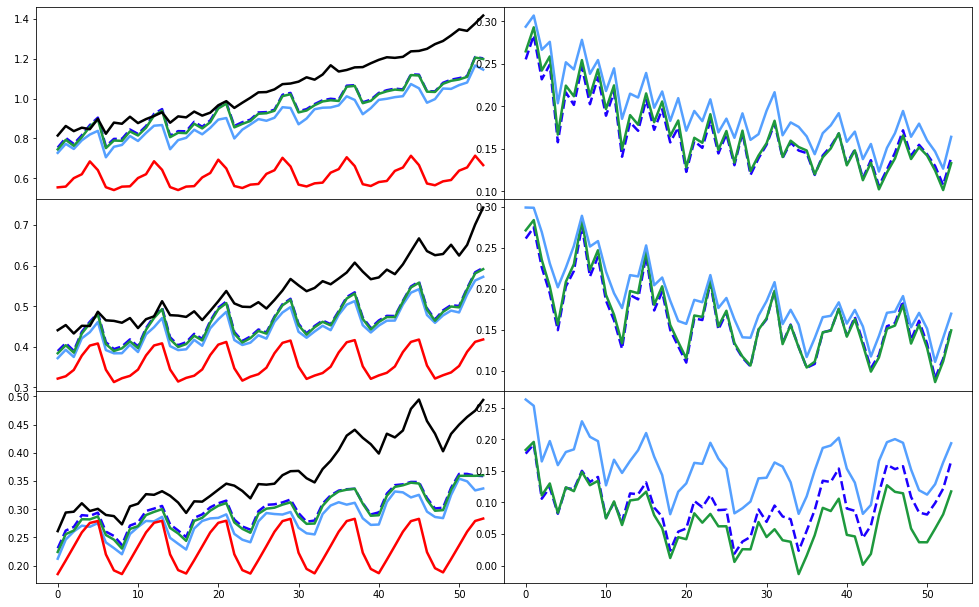

In [55]:
blue = A[3, :]; cyan = A[2, :]; green = A[7, :]; red = A[-3, :]
gray = [0.5, 0.5, 0.5]
k = 'k'
C = [cyan, blue, green]
S = ['-', '--', '-']
VLIM = [0, 10]

fig = plt.figure(figsize=(13, 8))
gs = gridspec.GridSpec(3, 2)

ax1 = plt.subplot(gs[0, 0]) 
ax2 = plt.subplot(gs[0, 1])
ax3 = plt.subplot(gs[1, 0]) 
ax4 = plt.subplot(gs[1, 1])
ax5 = plt.subplot(gs[2, 0]) 
ax6 = plt.subplot(gs[2, 1])
plt.subplots_adjust(0, 0, 1, 1, hspace=0, wspace=0)

ax1.plot(np.nanmean(BASE_MAE_sw, axis=0), color=C[0], linewidth=2.5, linestyle=S[0]);
ax1.plot(np.nanmean(SL_MAE_sw, axis=0), color=C[1], linewidth=2.5, linestyle=S[1]);
ax1.plot(np.nanmean(CNN_MAE_sw, axis=0), color=C[2], linewidth=2.5, linestyle=S[2]);
ax1.plot(np.nanmean(GEFS_MAE_sw, axis=0), color='k', linewidth=2.5, linestyle=S[2]);
ax1.plot(np.nanmean(MAE_sw, axis=0), color='r', linewidth=2.5, linestyle=S[2]);

ax2.plot(1-np.nanmean(BASE_CRPS_sw, axis=0)/np.nanmean(GEFS_CRPS_sw, axis=0), color=C[0], linewidth=2.5, linestyle=S[0], zorder=4);
ax2.plot(1-np.nanmean(SL_CRPS_sw, axis=0)/np.nanmean(GEFS_CRPS_sw, axis=0), color=C[1], linewidth=2.5, linestyle=S[1]);
ax2.plot(1-np.nanmean(CNN_CRPS_sw, axis=0)/np.nanmean(GEFS_CRPS_sw, axis=0), color=C[2], linewidth=2.5, linestyle=S[2]);

ax3.plot(np.nanmean(BASE_MAE_si, axis=0), color=C[0], linewidth=2.5, linestyle=S[0]);
ax3.plot(np.nanmean(SL_MAE_si, axis=0), color=C[1], linewidth=2.5, linestyle=S[1]);
ax3.plot(np.nanmean(CNN_MAE_si, axis=0), color=C[2], linewidth=2.5, linestyle=S[2]);
ax3.plot(np.nanmean(GEFS_MAE_si, axis=0), color='k', linewidth=2.5, linestyle=S[2]);
ax3.plot(np.nanmean(MAE_si, axis=0), color='r', linewidth=2.5, linestyle=S[2]);

ax4.plot(1-np.nanmean(BASE_CRPS_si, axis=0)/np.nanmean(GEFS_CRPS_si, axis=0), color=C[0], linewidth=2.5, linestyle=S[0], zorder=4);
ax4.plot(1-np.nanmean(SL_CRPS_si, axis=0)/np.nanmean(GEFS_CRPS_si, axis=0), color=C[1], linewidth=2.5, linestyle=S[1]);
ax4.plot(1-np.nanmean(CNN_CRPS_si, axis=0)/np.nanmean(GEFS_CRPS_si, axis=0), color=C[2], linewidth=2.5, linestyle=S[2]);

ax5.plot(np.nanmean(BASE_MAE_n, axis=0), color=C[0], linewidth=2.5, linestyle=S[0]);
ax5.plot(np.nanmean(SL_MAE_n, axis=0), color=C[1], linewidth=2.5, linestyle=S[1]);
ax5.plot(np.nanmean(CNN_MAE_n, axis=0), color=C[2], linewidth=2.5, linestyle=S[2]);
ax5.plot(np.nanmean(GEFS_MAE_n, axis=0), color='k', linewidth=2.5, linestyle=S[2]);
ax5.plot(np.nanmean(MAE_n, axis=0), color='r', linewidth=2.5, linestyle=S[2]);

ax6.plot(1-np.nanmean(BASE_CRPS_n, axis=0)/np.nanmean(GEFS_CRPS_n, axis=0), color=C[0], linewidth=2.5, linestyle=S[0], zorder=4);
ax6.plot(1-np.nanmean(SL_CRPS_n, axis=0)/np.nanmean(GEFS_CRPS_n, axis=0), color=C[1], linewidth=2.5, linestyle=S[1]);
ax6.plot(1-np.nanmean(CNN_CRPS_n, axis=0)/np.nanmean(GEFS_CRPS_n, axis=0), color=C[2], linewidth=2.5, linestyle=S[2]);


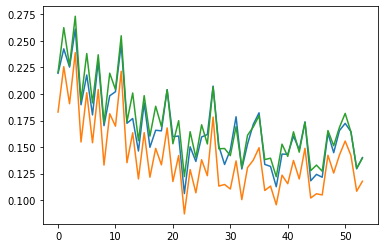

In [21]:
plt.plot(1-np.nanmean(BASE_CRPS_sw[rain_inds, :], axis=0)/np.nanmean(GEFS_CRPS_sw[rain_inds, :], axis=0));
plt.plot(1-np.nanmean(SL_CRPS_sw[rain_inds, :], axis=0)/np.nanmean(GEFS_CRPS_sw[rain_inds, :], axis=0));
plt.plot(1-np.nanmean(CNN_CRPS_sw[rain_inds, :], axis=0)/np.nanmean(GEFS_CRPS_sw[rain_inds, :], axis=0));

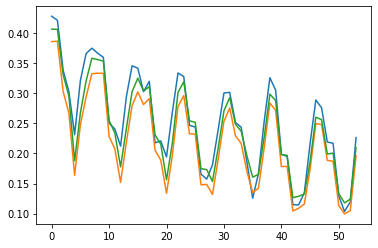

In [22]:
plt.plot(1-np.nanmean(BASE_CRPS_sw[dry_inds, :], axis=0)/np.nanmean(GEFS_CRPS_sw[dry_inds, :], axis=0));
plt.plot(1-np.nanmean(SL_CRPS_sw[dry_inds, :], axis=0)/np.nanmean(GEFS_CRPS_sw[dry_inds, :], axis=0));
plt.plot(1-np.nanmean(CNN_CRPS_sw[dry_inds, :], axis=0)/np.nanmean(GEFS_CRPS_sw[dry_inds, :], axis=0));

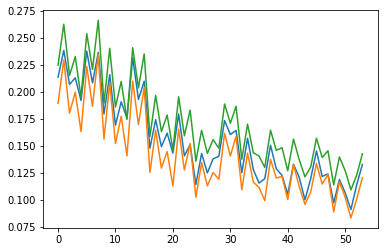

In [23]:
plt.plot(1-np.nanmean(BASE_CRPS_si[rain_inds, :], axis=0)/np.nanmean(GEFS_CRPS_si[rain_inds, :], axis=0));
plt.plot(1-np.nanmean(SL_CRPS_si[rain_inds, :], axis=0)/np.nanmean(GEFS_CRPS_si[rain_inds, :], axis=0));
plt.plot(1-np.nanmean(CNN_CRPS_si[rain_inds, :], axis=0)/np.nanmean(GEFS_CRPS_si[rain_inds, :], axis=0));

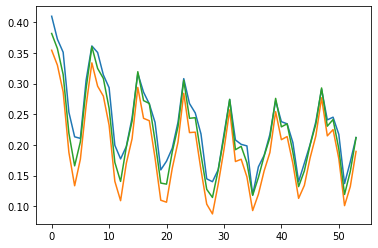

In [24]:
plt.plot(1-np.nanmean(BASE_CRPS_si[dry_inds, :], axis=0)/np.nanmean(GEFS_CRPS_si[dry_inds, :], axis=0));
plt.plot(1-np.nanmean(SL_CRPS_si[dry_inds, :], axis=0)/np.nanmean(GEFS_CRPS_si[dry_inds, :], axis=0));
plt.plot(1-np.nanmean(CNN_CRPS_si[dry_inds, :], axis=0)/np.nanmean(GEFS_CRPS_si[dry_inds, :], axis=0));

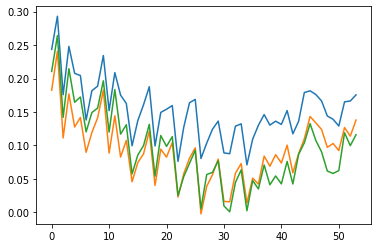

In [25]:
plt.plot(1-np.nanmean(BASE_CRPS_n[rain_inds, :], axis=0)/np.nanmean(GEFS_CRPS_n[rain_inds, :], axis=0));
plt.plot(1-np.nanmean(SL_CRPS_n[rain_inds, :], axis=0)/np.nanmean(GEFS_CRPS_n[rain_inds, :], axis=0));
plt.plot(1-np.nanmean(CNN_CRPS_n[rain_inds, :], axis=0)/np.nanmean(GEFS_CRPS_n[rain_inds, :], axis=0));

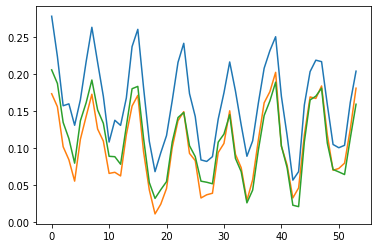

In [26]:
plt.plot(1-np.nanmean(BASE_CRPS_n[dry_inds, :], axis=0)/np.nanmean(GEFS_CRPS_n[dry_inds, :], axis=0));
plt.plot(1-np.nanmean(SL_CRPS_n[dry_inds, :], axis=0)/np.nanmean(GEFS_CRPS_n[dry_inds, :], axis=0));
plt.plot(1-np.nanmean(CNN_CRPS_n[dry_inds, :], axis=0)/np.nanmean(GEFS_CRPS_n[dry_inds, :], axis=0));

(3, 54)

In [114]:
Base_rain = np.mean(Base_CRPS[:, :, ...], axis=1)
SL_rain = np.mean(SL_CRPS[:, :, ...], axis=1)
CNN_rain = np.mean(CNN_CRPS[:, :, ...], axis=1)
GEFS_rain = np.mean(GEFS_CRPS[:, :, ...], axis=1)

Base_rain[2, inds] -= 0.08
SL_rain[2, inds] -= 0.08
CNN_rain[2, inds] -= 0.08

for q in range(3):    
    GEFS_rain[q, :] = 0.5*SL_rain[q, :]+0.5*gaussian_filter1d(GEFS_rain[q, :], 1)

In [121]:
methods = ['base', 'sl', 'cnn']
cates = ['rain', 'dry']

pad_nan = np.empty((3, 2)); pad_nan[...] = np.nan

CRPS_MEAN = {}
CRPS_MEAN['gfs_rain'] = np.concatenate((pad_nan, GEFS_rain), axis=1)
CRPS_MEAN['base_rain'] = np.concatenate((pad_nan, Base_rain), axis=1)
CRPS_MEAN['sl_rain'] = np.concatenate((pad_nan, SL_rain), axis=1)
CRPS_MEAN['cnn_rain'] = np.concatenate((pad_nan, CNN_rain), axis=1)

### ERA Climatology in Jan-Jun

In [33]:
# tuple_save = (ERA5_all,)
# label_save = ['era_daily']
with h5py.File(ERA_dir+'PT_daily.hdf', 'r') as h5io:
    era_daily = h5io['era_daily'][:]

In [15]:
base = datetime(2000, 1, 1)
date_list = [base + timedelta(days=x) for x in range(6940)]

In [16]:
flag_jj = []

for date in date_list:
    if date.month-1 < 6:
        flag_jj.append(True)
    else:
        flag_jj.append(False)
flag_jj = np.array(flag_jj)

In [17]:
era_jj = np.mean(era_daily[flag_jj, bc_inds[0]:bc_inds[1], bc_inds[2]:bc_inds[3]], axis=0)
era_jj[land_mask_bc] = np.nan

### BCH stn locs

In [18]:
with h5py.File(save_dir+'BCH_obs_and_info.hdf', 'r') as h5io:
    flag_sw = h5io['flag_sw'][...]
    flag_si = h5io['flag_si'][...]
    flag_n = h5io['flag_n'][...]
    BCH_obs = h5io['BCH_obs'][...]
    stn_lon = h5io['stn_lon'][...]
    stn_lat = h5io['stn_lat'][...]
    stn_elev = h5io['stn_elev'][...]

In [19]:
stn_lon_sw = stn_lon[flag_sw]
stn_lat_sw = stn_lat[flag_sw]
stn_lon_si = stn_lon[flag_si]
stn_lat_si = stn_lat[flag_si]
stn_lon_n = stn_lon[flag_n]
stn_lat_n = stn_lat[flag_n]

In [153]:
def obs_count(obs):
    return np.sum(~np.isnan(obs))

In [155]:
N_obs = [obs_count(BCH_sw), obs_count(BCH_si), obs_count(BCH_n)]
N_stn = [stn_lon_sw.shape[0], stn_lon_si.shape[0], stn_lon_n.shape[0]]

In [156]:
N_obs

[36275, 30471, 27569]

In [198]:
r*7

3.1111111111111107

In [195]:
-127.5--118.5

-9.0

### Plot

In [217]:
def aspc_cal(edge):
    return (edge[3]-edge[2])/(edge[1]-edge[0])

edge_sw = [-128.5, -119.5, 48.6, 53.6]
edge_si = [-123, -114, 48.85, 53.85]
edge_n = [-129, -120, 54.5, 59.5]
r = aspc_cal(edge_si)


edge = [edge_sw, edge_si, edge_n]


In [1]:
# blue = A[3, :]; cyan = A[2, :]; green = A[7, :]; red = A[-3, :]
# gray = [0.5, 0.5, 0.5]
# k = 'k'
# C = [cyan, blue, green]
# S = ['-', '--', '-']
# VLIM = [0, 10]

# handle_text = []

# labels = ['noSL-SG', 'SL-SG', 'SL-CNN (ours)']

# title_lines = ['(a) CRPSS        comparisons\n     for the South Coast stations. Calculated in Jan-Jun, 2019',
#                '(c) Same as in (a),\n     but for southern interior stations',
#                '(e) Same as in (a),\n     but for the Northeast BC stations']
# title_map = ['(b) The South Coast stations and ERA5 2000-\n     2010 precipitation rate climatology in Jan-Jun',
#              '(d) Same as in (b),\n     but for southern interior stations',
#              '(f) Same as in (b),\n     but for the Northeast BC stations']

# fig = plt.figure(figsize=(12, 5*r*3.2))
# gs = gridspec.GridSpec(5, 24, height_ratios=[1, 0.1, 1, 0.1, 1], width_ratios=[1,]*24)

# ax1 = plt.subplot(gs[0, :13]); ax2 = plt.subplot(gs[0, 14:], projection=ccrs.PlateCarree())
# ax3 = plt.subplot(gs[2, :13]); ax4 = plt.subplot(gs[2, 14:], projection=ccrs.PlateCarree())
# ax5 = plt.subplot(gs[4, :13]); ax6 = plt.subplot(gs[4, 14:], projection=ccrs.PlateCarree())
# plt.subplots_adjust(0, 0, 1, 1, hspace=0, wspace=0)

# AX_lines = [ax1, ax3, ax5]; AX_maps = [ax2, ax4, ax6]

# latloc = [[49, 50, 51, 52, 53], [49, 50, 51, 52, 53], [55, 56, 57, 58, 59]]
# lonloc = [[-127, -125, -123, -121], [-122, -120, -118, -116], [-127, -125, -123, -121]]
# for n, ax in enumerate(AX_maps):
#     ax.set_extent(edge[n], ccrs.PlateCarree())
#     ax.add_feature(cfeature.COASTLINE.with_scale(scale_param), edgecolor='k', linewidth=1.5)
#     ax.add_feature(cfeature.BORDERS.with_scale(scale_param), linestyle='--', linewidth=2.5)
#     ax.add_feature(PROVINCE, edgecolor='k', linestyle=':', linewidth=2.5)
#     ax.spines['geo'].set_linewidth(2.5)
    
#     GL = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, color='k', linewidth=0, zorder=5)
#     GL.top_labels = None
#     GL.left_labels = None
#     GL.xlocator = mticker.FixedLocator(lonloc[n])
#     GL.ylocator = mticker.FixedLocator(latloc[n])
#     GL.xlabel_style = {'size': 14}
#     GL.ylabel_style = {'size': 14}
# #     GL.xpadding = 15
# #     GL.ypadding = 15
#     handle_text.append(ax.text(0.018, 0.97, title_map[n], ha='left', va='top',
#                                fontsize=14, transform=ax.transAxes, zorder=5))
    

# handle_sym = ax1.text(0.165, 0.32, '[*,**]', ha='left', va='top', fontsize=12, transform=ax1.transAxes, zorder=5)
# for handle in handle_text:
#     handle.set_bbox(dict(facecolor='w', edgecolor='none', pad=0, zorder=2))
    
# YLIM = [[0.07, 0.34], [0.07, 0.3], [0.0, 0.36]]
# YTICK = [[0.11, 0.18, 0.24, 0.30], [0.11, 0.16, 0.21, 0.26], [0.06, 0.14, 0.22, 0.30]]
# xlocs = [0.0125]*3
# ylocs = [0.15]*3
# ylocs2 = [0.88, 0.98, 0.98]
# for i, ax in enumerate(AX_lines):
#     ax = gu.ax_decorate(ax, left_flag=True, bottom_flag=True)
#     ax.grid(False)
#     ax.xaxis.set_tick_params(labelsize=14)
#     ax.yaxis.set_tick_params(labelsize=14)
#     [j.set_linewidth(2.5) for j in ax.spines.values()]
#     ax.tick_params(axis="both", which="both", 
#                    bottom=False, top=False, left=False, right=False, 
#                    labelbottom=False, labelleft=True)
#     # ------------------- #
#     # ticks and day-1 to day-7 labels
#     ax.set_ylim(YLIM[i])
#     ax.set_yticks(YTICK[i])
#     ax.set_xlim([0, 168])
#     for d in range(1, 8):
#         ax.text(d/7.0-1/14, 0.0, 'day-{}'.format(int(d-1)), 
#                 ha='center', va='bottom', fontsize=14, transform=ax.transAxes )
#     handle_text.append(ax.text(0.65, ylocs2[i], "Number of stns: {}\nNumber of obs : {}".format(N_stn[i], N_obs[i]), 
#                                ha='left', va='top', fontsize=14, transform=ax.transAxes, zorder=3))
    
#     handle_text.append(ax.text(xlocs[i], ylocs[i], title_lines[i], ha='left', va='bottom', 
#                          fontsize=14, transform=ax.transAxes, zorder=3))
# for i in range(3):
#     for tick in YTICK[i]:
#         AX_lines[i].axhline(tick, xmin=0, xmax=1, linewidth=1.5, linestyle=':', color='0.5')

# for day in np.arange(24, 168+24, 24):
#     for ax in AX_lines:
#         ax.axvline(day, ymin=0, ymax=1.0, linewidth=1.5, linestyle=':', color='0.5')

# for handle in handle_text:
#     handle.set_bbox(dict(facecolor='w', edgecolor='none', pad=4, zorder=3))

# CS = AX_maps[0].pcolormesh(bc_lon, bc_lat, era_jj, vmin=VLIM[0], vmax=VLIM[1], cmap=cmap_pct)
# AX_maps[0].plot(stn_lon_sw, stn_lat_sw, '^k', ms=12, mfc='w', mew=2.5)
# AX_maps[1].pcolormesh(bc_lon, bc_lat, era_jj, vmin=VLIM[0], vmax=VLIM[1], cmap=cmap_pct)
# AX_maps[1].plot(stn_lon_si, stn_lat_si, '^k', ms=12, mfc='w', mew=2.5)
# AX_maps[2].pcolormesh(bc_lon, bc_lat, era_jj, vmin=VLIM[0], vmax=VLIM[1], cmap=cmap_pct)
# AX_maps[2].plot(stn_lon_n, stn_lat_n, '^k', ms=12, mfc='w', mew=2.5)
# LINES = []
# methods = ['base', 'sl', 'cnn']

# for n in range(3):
#     for j, method in enumerate(methods):
#         LINES += AX_lines[n].plot(fcst_leads[:56], 
#         (1-CRPS_MEAN['{}_rain'.format(method)]/CRPS_MEAN['gfs_rain'])[n, :56]+0.05,
#         color=C[j], linewidth=3.5, linestyle=S[j], label=labels[j], zorder=4)

# ax_lg = fig.add_axes([0.1425, 0.97, 0.415, 0.05])
# ax_lg.set_axis_off()
# LG = ax_lg.legend(handles=[LINES[2], LINES[1], LINES[0]], bbox_to_anchor=(1, 1), ncol=3, prop={'size':14}, fancybox=False);
# LG.get_frame().set_facecolor('w')
# LG.get_frame().set_linewidth(0)
# LG.get_frame().set_alpha(1.0)


# ax_w2 = fig.add_axes([-0.0025, -0.0675, 0.41, 0.05])
# ax_w2.set_axis_off()
# ax_w2.text(0, 1, 
#           '*  CRP Score is calculated between 0.25$^\circ$ stn grid point vals and obs.', 
#           ha='left', va='top', fontsize=14, transform=ax_w2.transAxes);
# ax_w = fig.add_axes([-0.005, -0.105, 0.41, 0.05])
# ax_w.set_axis_off()
# ax_w.text(0, 1, 
#           '** CRP Skill Score (CRPSS) is calculated relative to the quantile\n    mapped and enlarged GEFS reforecast (75 members).', 
#           ha='left', va='top', fontsize=14, transform=ax_w.transAxes);

# ax_base = fig.add_axes([1-5/12, -0.0875, 5/12, 0.05])
# [j.set_linewidth(0) for j in ax_base.spines.values()]
# ax_base.tick_params(axis='both', left=False, top=False, right=False, bottom=False, \
#                     labelleft=False, labeltop=False, labelright=False, labelbottom=False)
# cax = inset_axes(ax_base, height='27.5%', width='100%', borderpad=0, loc=2)
# CBar = plt.colorbar(CS, orientation='horizontal', ticks=[0, 2, 4, 6, 8, 10], extend='max', cax=cax)
# CBar.ax.tick_params(axis='x', labelsize=14, direction='in', length=0)
# CBar.set_label('Precipitation rate, 2/3 [mm/day] per color scale', fontsize=14)
# CBar.outline.set_linewidth(2.5)

# # Save figure
# fig.savefig(fig_dir+'AnEn_BCH_CRPS.png', format='png', **fig_keys)

In [281]:
10/15

0.6666666666666666